# Statistical Analysis
In this file, we will perform **statistical analysis** for the ASUU Strike Effect Analysis Project. The statistical analysis performed will be based on the result of the **exploratory data analysis**.

## Importing necessary models

In [3]:
#!pip install scikit_posthocs

In [4]:
from scipy.stats import f_oneway, kruskal, ttest_ind, anderson
import scikit_posthocs as sp
from scipy import stats
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import utils
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [5]:
grey = "#eeeeee"
blue = "#4276A5"
red = "#cf8989"
cream = "#f9cb9c"
green = "#45818e"
pink = "#FF8FC3"

PALETTE = [red, cream, blue, green, pink, grey]
FONT = "Verdana"

# Set Seaborn style and color palette
sns.set(
    style="white", 
    palette=PALETTE, 
    context='notebook', 
    font=FONT, 
    font_scale=0.85, 
    color_codes=True
    )

# Set Matplotlib font
mpl.rcParams['font.family'] = FONT

# Set the desired axes border linewidth
mpl.rcParams['axes.linewidth'] = 0.2

This is temporary, for some reason, utils isn't working.

In [6]:
def anova_assumptions_test(feature, target, df):
    '''
    This function tests the assumptions required for the ANOVA statistical test.

    feature: The feature being tested for ANOVA assumptions.
    target: The column to aggregate for ANOVA.
    df: The dataframe containing the data.

    Returns one of four strings:
    1. The given data passes both tests of homoscedasticity and normality.
    2. The given data passes the test of homoscedasticity but fails the test of normality.
    3. The given data passes the test of normality but fails the test of homoscedasticity.
    4. The given data fails both tests of homoscedasticity and normality.
    '''
    # Homoscedasticity
    feature_std = df.groupby(feature)[target].std()
    max_std = feature_std.max()
    min_std = feature_std.min()

    # Normality
    normality = anderson_darling(df=df, feature=feature, target=target, alpha=5)

    if min_std * 2 >= max_std and normality:
        return 'The given data passes both tests of homoscedasticity and normality.'
    elif min_std * 2 >= max_std and not normality:
        return 'The given data passes the test of homoscedasticity but fails the test of normality.'
    elif min_std * 2 < max_std and normality:
        return 'The given data passes the test of normality but fails the test of homoscedasticity.'
    else:
        return 'The given data fails both tests of homoscedasticity and normality.'


def anderson_darling(df,feature,alpha,target):
  '''
  This function tests for normality in the df.
  
  df: The dataframe that contains the df you want to test.
  feature: The feature being tested for normality.
  target: The column to aggregate.
  alpha: The significance level for the statistical test. Default 0.05 or 5%.                                                   
  alpha should be inserted as a percentage in integer form, eg, 5% should be inserted as 5.
  
  Returns: True or False
  True means that the data follows a normal distribution.
  False means that the data doesn't follows a normal distribution.
  '''
  unique = df[feature].unique()
  counter = []

  for unique_value in unique:
    test_data = df[df[feature]==unique_value][target]
    
    if len(test_data) < 5:
        pass
    
    else:
        result = anderson(test_data)
        test_statistic = result.statistic
        critical_values = list(result.critical_values)
        significance_level = list(result.significance_level)
        index_sig_level = significance_level.index(alpha)

        if test_statistic <= critical_values[index_sig_level]:
            # It follows a normal distribution.
            counter.append(True)
        
        else:
            # It does not follow a normal distribution
            pass
    
  if False in counter:
      return False
  else:
      return True
  

def perform_one_way_anova(df, feature, target):
    '''
    Perform a one-way ANOVA test to assess the equality of means among multiple groups.
    
    Parameters:
        df (DataFrame): The DataFrame containing the data.
        feature (str): The column name for the categorical levels.
        target (str): The column name for the continuous variable (CGPA change).

    Returns:
        result (F_onewayResult): The result of the one-way ANOVA test.
    '''
    unique_levels = df[feature].unique()
    levels_data = {level: df[df[feature] == level][target] for level in unique_levels}
    
    result = f_oneway(*levels_data.values())
    
    return (f'ANOVA F-statistic:", {result.statistic}, "ANOVA p-value:", {result.pvalue}')


def perform_pairwise_tukeyhsd(df, feature, target):
    '''
    Perform pairwise Tukey's Honestly Significant Difference (HSD) test to compare group means.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        feature (str): The column name for the categorical groups.
        target (str): The column name for the data to be compared.

    Returns:
        tukey_result (MultiComparison): The result of the pairwise Tukey's HSD test.
    '''
    tukey_result = pairwise_tukeyhsd(
        endog=df[target],
        groups=df[feature]
    )
    print(tukey_result)
    
    
def perform_kruskal_willis_test(df, feature, target, min_count=5):
    '''
    Perform the Kruskal-Wallis test after filtering out groups with low counts.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        feature (str): The column name for the categorical groups.
        target (str): The column name for the data to be compared.
        min_count (int): Minimum count required for each group. Groups with counts below this are dropped.

    Returns:
        kruskal_result (KruskalResult): The result of the Kruskal-Wallis test.
    '''
    group_counts = df[feature].value_counts()
    low_count_groups = group_counts.index[group_counts < min_count]
    filtered_df = df[~df[feature].isin(low_count_groups)]

    groups_data = {group: filtered_df[filtered_df[feature] == group][target] for group in filtered_df[feature].unique()}

    kruskal_result = kruskal(*groups_data.values())
    return (f"Kruskal-Wallis Test statistic:, {kruskal_result.statistic}, Kruskal-Wallis Test p-value:, {kruskal_result.pvalue}")


def perform_pairwise_dunn(df, target, feature,p_adjust='bonferroni'):
    '''
    Perform pairwise Dunn's test to compare group means.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        feature (str): The column name for the categorical groups.
        target (str): The column name for the data to be compared.
        method (str): The multiple comparison correction method. Default is 'bonf'.
                      Other options: 'bonf', 'holm', 'fdr_bh', 'simes-hochberg'.

    Returns:
        dunn_result (DataFrame): The result of the pairwise Dunn's test.
    '''
    dunn_result = sp.posthoc_dunn(
        df[target],
        df[feature],
        p_adjust=p_adjust
    )
    print(dunn_result)
    

In [7]:
def generate_subplots(data, x_col, row_col, row_order=None, aspect=12/7):
    unique_labels = data[row_col].unique()
    num_unique_labels = len(unique_labels)
    num_cols = 1 if num_unique_labels <= 2 else num_unique_labels

    g = sns.displot(
        kind='hist',
        data=data,
        x=x_col,
        row=row_col,
        aspect=aspect,
        row_order=row_order
    )

    population_cgpa_average = data[x_col].mean()

    for label, ax in zip(unique_labels, g.axes.flat):
        ax.axvline(population_cgpa_average, color='red', label='Population CGPA Average')
        ax.legend(loc='upper right')
        ax.set_title(f'{row_col.capitalize()}: {label}')

    plt.tight_layout()

    plt.show()

## Reading and previewing data

In [8]:
# all data here include predicted course units

# complete info
df = pd.read_csv("../data/data_with_predicted_course_units.csv")

# contains students with no cgpa before or after 
df_invalid_cgpa = pd.read_csv("../data/incomplete_cgpa_only.csv")

# only contains students with complete cgpa information
df_valid_cgpa = pd.read_csv("../data/valid_cgpa_only.csv")

In [9]:
df_valid_cgpa.head(2)

,school,level,age,gender,relationship,faculty,department,strike_effect,challenge,work,skills,prep_before,prep_after,lecture,academic_act,courses_taken,course_unit,cgpa_before,cgpa_after,cgpa_change
0,university of lagos,400 Level,22,Male,Single,Engineering,Chemical engineering,I learned how to study better and my grades al...,Trying to remember things we were taught befor...,Worked in a role relevant to my studies,Acquired skills unrelated to course of study,Poorly,Poorly,No noticeable change,Rarely: I engaged in academic activities once ...,10,23,3.39,3.51,0.12
1,university of lagos,400 Level,23,Female,Single,Engineering,Chemical engineering,It affected it in a negative way as it became ...,"Rekindling the student in me, lol. Trying to g...",Did not work during the strike,Acquired skills unrelated to course of study,Poorly,Moderately,No noticeable change,Rarely: I engaged in academic activities once ...,10,23,4.44,4.50,0.06


In [10]:
df_valid_cgpa.isna().sum()

#Why do we have missing values?

school            0
level             0
age               0
gender            0
relationship      0
faculty           0
department        0
strike_effect    60
challenge        63
work              0
skills            0
prep_before       0
prep_after        0
lecture           0
academic_act      0
courses_taken     0
course_unit       0
cgpa_before       0
cgpa_after        0
cgpa_change       0
dtype: int64

## Removing insignificant groups

In [11]:
df_valid_cgpa[(df_valid_cgpa['level'] == '100 Level')]

,school,level,age,gender,relationship,faculty,department,strike_effect,challenge,work,skills,prep_before,prep_after,lecture,academic_act,courses_taken,course_unit,cgpa_before,cgpa_after,cgpa_change
61,university of lagos,100 Level,20,Male,Single,Sciences,Botany,Awan challenges yen poor gan.\r\nMelo melo ni ...,No money,Did not work during the strike,None of the above,Very,Poorly,Fewer lecturers attended classes,Rarely: I engaged in academic activities once ...,8,7,3.8,3.8,0.0
104,university of lagos,100 Level,20,Male,Single,Engineering,Electrical & electronics engineering,Wasted a lot of my time,Doing a crash course to pass exams and barely ...,Did not work during the strike,Acquired skills relevant to course of study,Poorly,Poorly,No noticeable change,Rarely: I engaged in academic activities once ...,6,1,2.9,2.9,0.0


We would have to filter those with 100 level and the likes out

In [12]:
# Dropping out-of-scope levels
df_valid_cgpa = df_valid_cgpa[~((df_valid_cgpa['level']=='600 Level') | (df_valid_cgpa['level']=='Masters Program') | (df_valid_cgpa['level']=='Postgraduate Diploma') | (df_valid_cgpa['level']=='100 Level'))]
df_valid_cgpa.level.unique()                                                                  

array(['400 Level', '300 Level', '200 Level', '500 Level'], dtype=object)

In [13]:
# Removing outlier row.
df_valid_cgpa = df_valid_cgpa[~(df_valid_cgpa['cgpa_change']==3.2)]

# Academic Level                                                                           

Feature: Academic Level

Null Hypothesis: There is no difference in the average cgpa change across academic levels.

Alternative Hypothesis: The Average cgpa change varies across academic levels.

Test Type: Two Tailed Test

Statistical Test: One Way ANOVA Test

Significance Level: 0.05

ANOVA Test Assumptions:
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

## Confirming Assumptions 

In [14]:
level_anova_assumptions = anova_assumptions_test(feature='level', target='cgpa_change', df=df_valid_cgpa)
print(level_anova_assumptions)

The given data passes both tests of homoscedasticity and normality.


## Hypothesis Testing on Academic Levels                                                                         

In [15]:
level_hypothesis_test = perform_one_way_anova(feature='level', target='cgpa_change', df=df_valid_cgpa)
level_hypothesis_test  

'ANOVA F-statistic:", 4.184646206134625, "ANOVA p-value:", 0.006365008572911084'

The p-value score of 0.0064 is less than the significance level of 0.05 this means that we reject the null hypothesis

**There is a significant difference between the average cgpa change across the different academic levels**                                                                     

## Interpreting the difference

While we've confirmed that a significant difference exist among the academic levels. The test carried out tells us nothing about the nature of this difference. To understand this difference, we can carry out post hoc tests to determine which specific pairs or groups differ significantly from the rest.                               

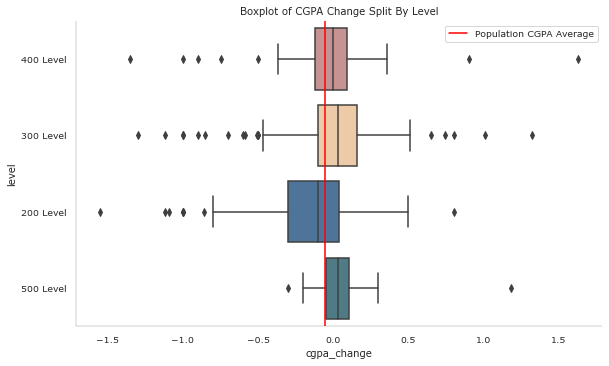

In [16]:
# Visualizing the difference
sns.catplot(
    kind='box',
    data=df_valid_cgpa,
    x='cgpa_change',
    y='level',
    aspect=12/7
)
plt.axvline(df_valid_cgpa.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
plt.title('Boxplot of CGPA Change Split By Level');

In [17]:
# Investigating pairwise differences                                                                                 
level_tukey_results = perform_pairwise_tukeyhsd(feature='level', target='cgpa_change', df=df_valid_cgpa)
level_tukey_results

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
200 Level 300 Level   0.1607 0.0125  0.0254  0.296   True
200 Level 400 Level   0.1299 0.1082 -0.0181  0.278  False
200 Level 500 Level   0.2355 0.0539 -0.0026 0.4737  False
300 Level 400 Level  -0.0308 0.9429 -0.1721 0.1105  False
300 Level 500 Level   0.0748 0.8423 -0.1592 0.3088  False
400 Level 500 Level   0.1056  0.672  -0.136 0.3472  False
---------------------------------------------------------


We can conclude from the reject column that there is a significant difference between the means of those in 200 and 300 level but no significant difference between any other group. This is supported visually. 200 level has the lowest 2nd quartile and 300 level has the highest 3 quartile. 

**The cgpa change of the 300 level students is significantly more than the cgpa change of 200 level students**

# Faculty

Feature: Faculty

Null Hypothesis: There is no difference in the average cgpa change across Faculty.

Alternative Hypothesis: The Average cgpa change varies across Faculty.

Test Type: Two Tailed Test

Statistical Test: One Way ANOVA Test

Significance Level: 0.05

ANOVA Test Assumptions:
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

## Confirming Assumptions 

In [18]:
faculty_anova_assumptions = anova_assumptions_test(feature='faculty', target='cgpa_change', df=df_valid_cgpa)
print(faculty_anova_assumptions)

The given data passes the test of normality but fails the test of homoscedasticity.


This feature fails homoscandesity test. We cannot use the Anova test to test the Hypothesis.

**We will use the Kruskal Willis Test.**
                                                       

## Hypothesis Testing on Faculty                                                                         

In [19]:
faculty_hypothesis_test = perform_kruskal_willis_test(feature='faculty', target='cgpa_change', df=df_valid_cgpa,min_count=5)
faculty_hypothesis_test  

'Kruskal-Wallis Test statistic:, 17.846018573361583, Kruskal-Wallis Test p-value:, 0.03700261022840909'

The p-value score of 0.037 is less than the significance level of 0.05 this means that we reject the null hypothesis

**There is a significant difference between the average cgpa change across the different faculties**

## Interpreting the difference

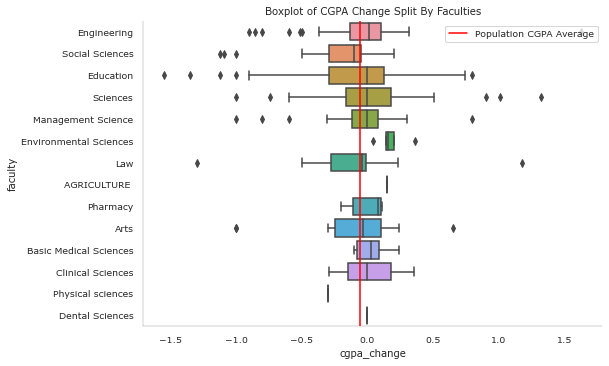

In [20]:
# Visualizing the difference
sns.catplot(
    kind='box',
    data=df_valid_cgpa,
    x='cgpa_change',
    y='faculty',
    aspect=12/7
)
plt.axvline(df_valid_cgpa.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
plt.title('Boxplot of CGPA Change Split By Faculties');

In [21]:
# Investigating pairwise differences      
dunn_result=sp.posthoc_dunn(df_valid_cgpa,val_col='cgpa_change',group_col='faculty',p_adjust='holm')
dunn_result

,AGRICULTURE,Arts,Basic Medical Sciences,Clinical Sciences,Dental Sciences,Education,Engineering,Environmental Sciences,Law,Management Science,Pharmacy,Physical sciences,Sciences,Social Sciences
AGRICULTURE,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000
Arts,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000
Basic Medical Sciences,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000
Clinical Sciences,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000
Dental Sciences,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000
Education,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000
Engineering,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000
Environmental Sciences,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,0.074117
Law,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000
Management Science,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000


## RESOLUTION

Results are inconclusive. The hypothesis test and post hoc analysis directly contradict each other. Asides what's displayed on the notebook, I also tried different combinations of two more statistical testing methods (ANOVA and Tukey_usd) to similar results.                                              

# Age

Feature: Age

Null Hypothesis: There is no significant difference in the cgpa of students older and younger than 21.

Alternative Hypothesis: There is a significant difference in the cgpa of students older and younger than 21.

Test Type: Two Tailed Test

Statistical Test: One Way ANOVA Test

Significance Level: 0.05

ANOVA Test Assumptions:
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

## Preprocessing

In [22]:
def age_cat(row):
    if row <= 21:
        return 'Less Than 21'
    else:
        return 'Older Than 21' 
    
df_valid_cgpa_temporary = df_valid_cgpa.copy()
df_valid_cgpa_temporary['age_cat'] = df_valid_cgpa.age.apply(age_cat)

In [23]:
df_valid_cgpa_temporary.head(1)

,school,level,age,gender,relationship,faculty,department,strike_effect,challenge,work,...,prep_before,prep_after,lecture,academic_act,courses_taken,course_unit,cgpa_before,cgpa_after,cgpa_change,age_cat
0,university of lagos,400 Level,22,Male,Single,Engineering,Chemical engineering,I learned how to study better and my grades al...,Trying to remember things we were taught befor...,Worked in a role relevant to my studies,...,Poorly,Poorly,No noticeable change,Rarely: I engaged in academic activities once ...,10,23,3.39,3.51,0.12,Older Than 21


In [24]:
df_valid_cgpa_temporary.age_cat.unique()

array(['Older Than 21', 'Less Than 21'], dtype=object)

## Confirming Assumptions 

In [25]:
age_anova_assumptions = anova_assumptions_test(feature='age_cat', target='cgpa_change', df=df_valid_cgpa_temporary)
print(age_anova_assumptions)

The given data passes both tests of homoscedasticity and normality.


## Hypothesis Testing on Age                                                         

In [26]:
age_hypothesis_test = perform_one_way_anova(feature='age_cat', target='cgpa_change', df=df_valid_cgpa_temporary)
age_hypothesis_test  

'ANOVA F-statistic:", 0.13957190912191791, "ANOVA p-value:", 0.7089682217418058'

The p-value score of 0.709 is more than the significance level of 0.05 this means that we fail to reject the null hypothesis

**There is no significant difference between the average cgpa change across the different age classes**

## Interpreting the results

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


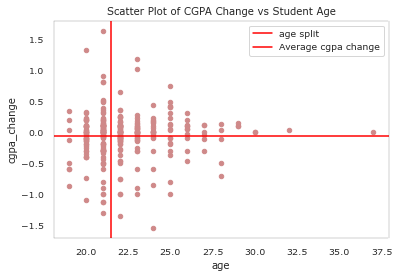

In [27]:
df_valid_cgpa.plot(kind='scatter',x='age',y='cgpa_change',title='Scatter Plot of CGPA Change vs Student Age')
plt.axvline(21.5,color='red',label='age split')
plt.axhline(df_valid_cgpa.cgpa_change.mean(),color='red', label='Average cgpa change')
plt.legend()

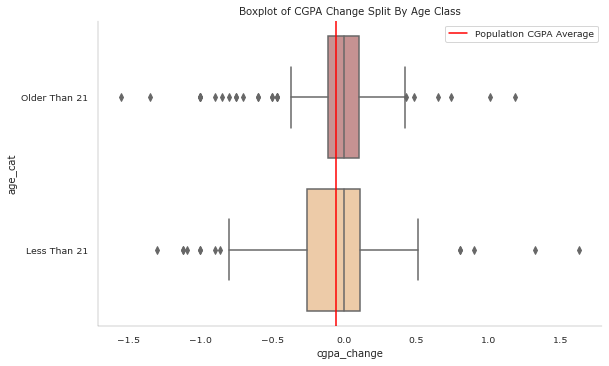

In [28]:
# Visualizing the difference
sns.catplot(
    kind='box',
    data=df_valid_cgpa_temporary,
    x='cgpa_change',
    y='age_cat',
    aspect=12/7
)
plt.axvline(df_valid_cgpa.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
plt.title('Boxplot of CGPA Change Split By Age Class');

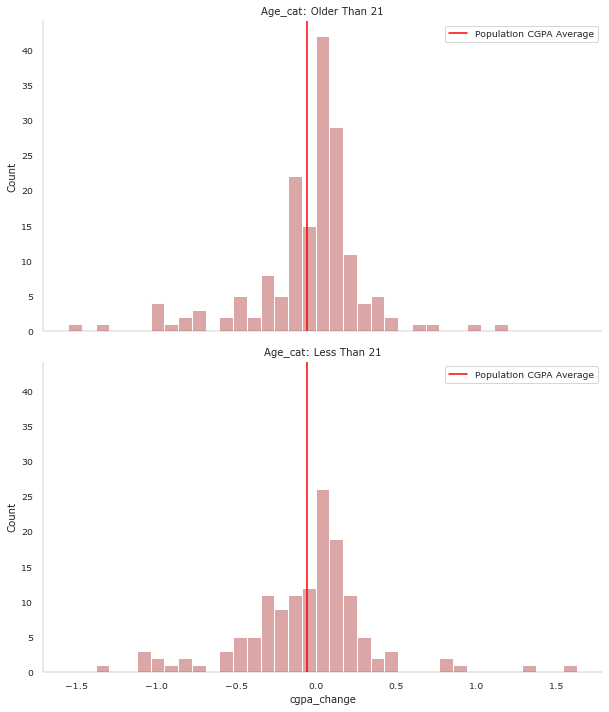

In [29]:
generate_subplots(df_valid_cgpa_temporary, x_col='cgpa_change', row_col='age_cat')

In [30]:

# g = sns.displot(
#     kind='hist',
#     data=df_valid_cgpa_temporary,
#     x='cgpa_change',
#     col='age_cat',
#     aspect=12/7
# )

# population_cgpa_average = df_valid_cgpa['cgpa_change'].mean()


# subplot_titles = ['Age Category: Older than 21', 'Age Category: Less than 21']

# # Loop through each subplot, add the red line, and set the title
# for idx, ax in enumerate(g.axes.flat):
#     ax.axvline(population_cgpa_average, color='red', label='Population CGPA Average')
#     ax.legend(loc='upper right')
#     ax.set_title(subplot_titles[idx])  # Set the title based on the index

    
# plt.show()

The Boxplot and Histogram both confirm that the change in CGPA is independent of age class.                                                                    

# Gender

Feature: Gender

Null Hypothesis: There is no significant difference in the cgpa of males and females.

Alternative Hypothesis: There is no significant difference in the cgpa of students males and females

Test Type: Two Tailed Test

Statistical Test: One Way ANOVA Test

Significance Level: 0.05

ANOVA Test Assumptions:
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

## Confirming Assumptions 

In [31]:
dgenderanova_assumptions = anova_assumptions_test(feature='gender', target='cgpa_change', df=df_valid_cgpa)
print(dgenderanova_assumptions)

The given data passes both tests of homoscedasticity and normality.


## Hypothesis Testing on Gender                                             

In [32]:
gender_hypothesis_test = perform_one_way_anova(feature='gender', target='cgpa_change', df=df_valid_cgpa)
gender_hypothesis_test  

'ANOVA F-statistic:", 0.28331724825381116, "ANOVA p-value:", 0.5949252552984301'

The p-value score of 0.5949 is greater than the significance level of 0.05 this means that we fail to reject the null hypothesis

**There is no significant difference between the average cgpa change across the different genders**

## Interpreting the results

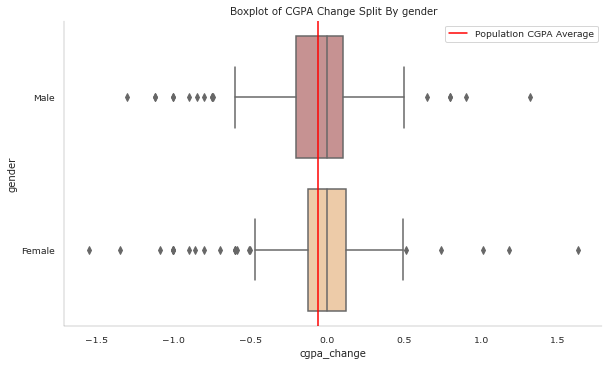

In [33]:
# Visualizing the results
sns.catplot(
    kind='box',
    data=df_valid_cgpa,
    x='cgpa_change',
    y='gender',
    aspect=12/7
)
plt.axvline(df_valid_cgpa.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
plt.title('Boxplot of CGPA Change Split By gender');

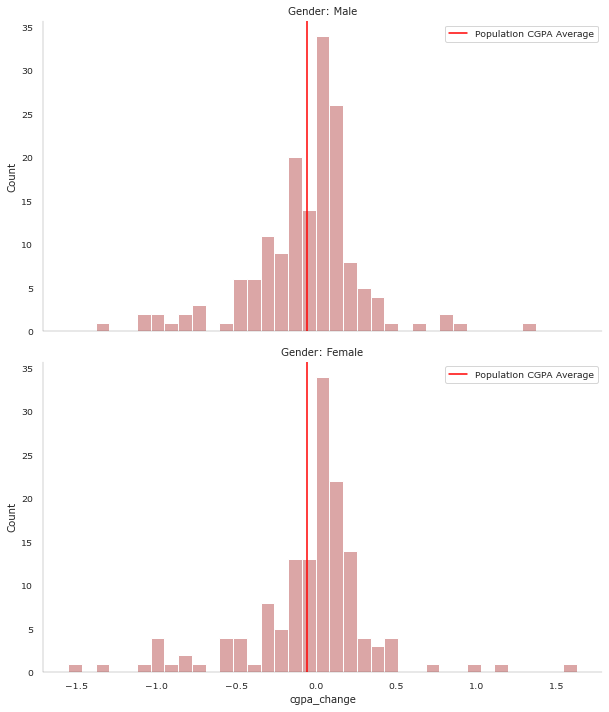

In [34]:
generate_subplots(df_valid_cgpa, x_col='cgpa_change', row_col='gender')

In [35]:
# # Visualizing the results
# sns.displot(
#     kind='hist',
#     data=df_valid_cgpa,
#     x='cgpa_change',
#     col='gender',
#     aspect=12/7
# )
# plt.axvline(df_valid_cgpa.cgpa_change.mean(),color='red',label='Population CGPA Average')      
# plt.legend(loc='upper right')                                                                           
# plt.title('Histogram of CGPA Change Split By gender');

The Boxplot and Histogram both confirm that the change in CGPA is independent of gender.                                                                    

# Relationship Status

Feature: Relationship Status

Null Hypothesis: There is no difference in the average cgpa change across Relationship status.

Alternative Hypothesis: The Average cgpa change varies across Relationship status.

Test Type: Two Tailed Test

Statistical Test: One Way ANOVA Test

Significance Level: 0.05

Test Assumptions:
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

## Confirming Assumptions

In [36]:
relationship_anova_assumptions = anova_assumptions_test(feature='relationship', target='cgpa_change', df=df_valid_cgpa)
print(relationship_anova_assumptions)

The given data passes the test of normality but fails the test of homoscedasticity.


This feature fails homoscandesity test. We cannot use the Anova test to test the Hypothesis.

**We will use the Kruskal Willis Test.**
                                                       

## Hypothesis Testing on Relationship Status                                         

In [37]:
relationship_hypothesis_test = perform_kruskal_willis_test(feature='relationship', target='cgpa_change', df=df_valid_cgpa,min_count=5)
relationship_hypothesis_test  

'Kruskal-Wallis Test statistic:, 0.43583777979683214, Kruskal-Wallis Test p-value:, 0.8041906670080009'

The p-value score of 0.804 is greater than the significance level of 0.05 this means that we fail to reject the null hypothesis.

**There is no significant difference between the average cgpa change across the different relationship_statuses**

## Interpreting the results

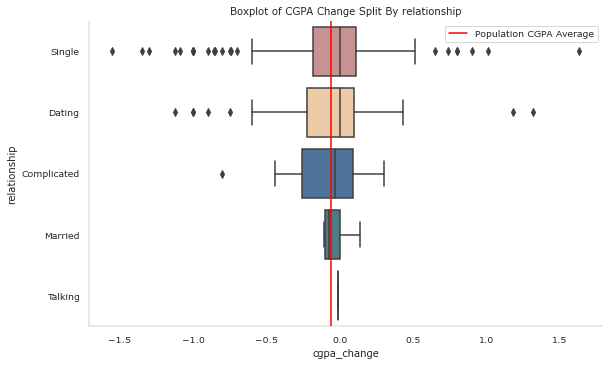

In [38]:
# Visualizing the difference
sns.catplot(
    kind='box',
    data=df_valid_cgpa,
    x='cgpa_change',
    y='relationship',
    aspect=12/7
)
plt.axvline(df_valid_cgpa.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
plt.title('Boxplot of CGPA Change Split By relationship');

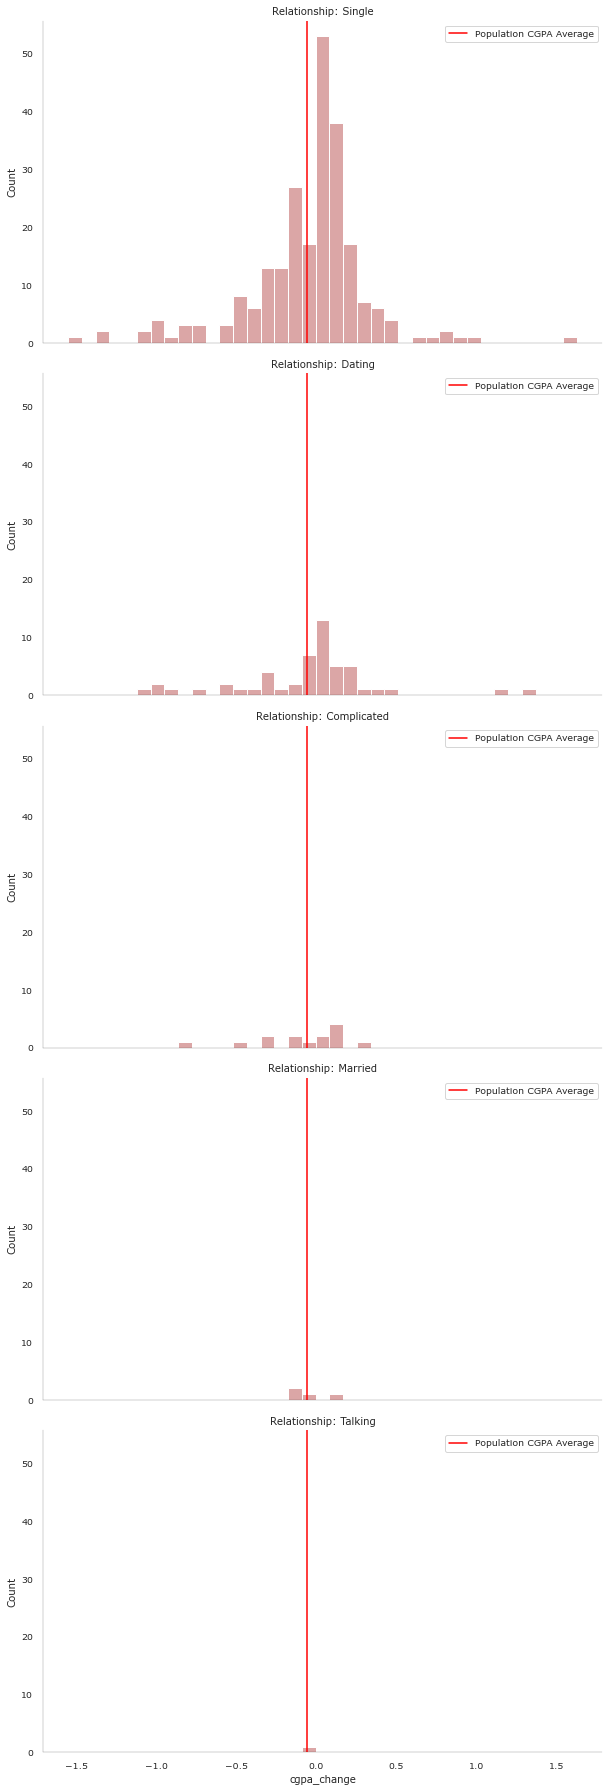

In [39]:
generate_subplots(df_valid_cgpa, x_col='cgpa_change', row_col='relationship')

The Boxplot and Histogram both confirm that the change in CGPA is independent of relationship status.                                                                    

# Worked

Feature: worked

Null Hypothesis: There is no significant difference in the cgpa of students with different working statuses.

Alternative Hypothesis: There is a significant difference in the cgpa of students with different working statuses. 

Test Type: Two Tailed Test

Statistical Test: One Way ANOVA Test

Significance Level: 0.05

ANOVA Test Assumptions:
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

## Confirming Assumptions 

In [40]:
worked_anova_assumptions = anova_assumptions_test(feature='work', target='cgpa_change', df=df_valid_cgpa)
print(worked_anova_assumptions)

The given data passes both tests of homoscedasticity and normality.


## Hypothesis Testing on work status.                                                                       

In [41]:
worked_hypothesis_test = perform_one_way_anova(feature='work', target='cgpa_change', df=df_valid_cgpa)
worked_hypothesis_test  

'ANOVA F-statistic:", 2.583026685351414, "ANOVA p-value:", 0.07721337074564746'

The p-value score of 0.077 is more than the significance level of 0.05 this means that we fail to reject the null hypothesis

**There is no significant difference between the average cgpa change across the different work status**                                                                     

## Interpreting the results

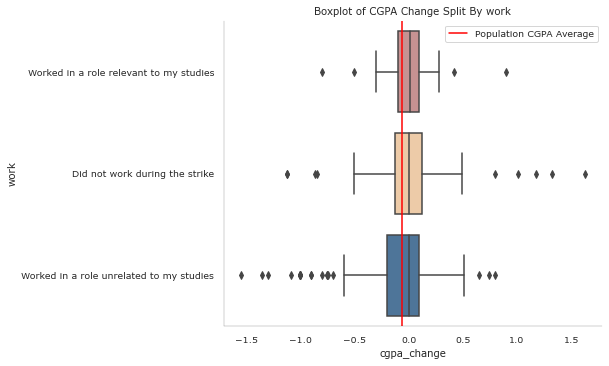

In [42]:
# Visualizing the result
sns.catplot(
    kind='box',
    data=df_valid_cgpa,
    x='cgpa_change',
    y='work',
    aspect=12/7
)
plt.axvline(df_valid_cgpa.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
plt.title('Boxplot of CGPA Change Split By work');

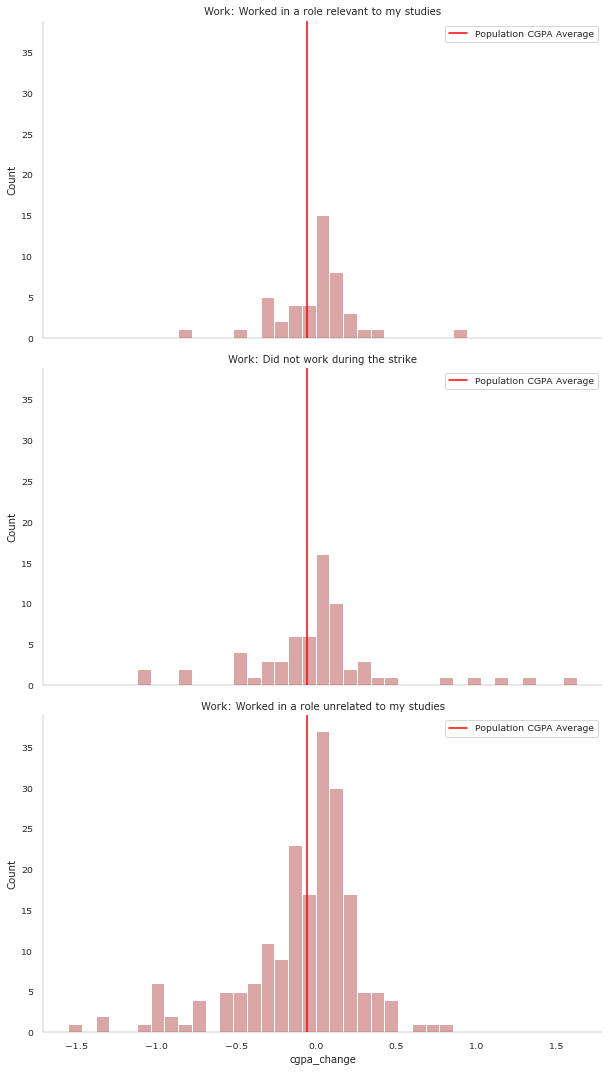

In [43]:
generate_subplots(df_valid_cgpa, x_col='cgpa_change', row_col='work')

The Boxplot and Histogram both confirm that the change in CGPA is independent of work status.                                                                    

# Academic Engagement

Feature: Academic Engagement

Null Hypothesis: There is no difference in the CGPA change across academic levels.

Alternative Hypothesis: There is a difference in the CGPA change across academic levels

Test Type: Two Tailed Test

Statistical Test: One Way ANOVA Test

Significance Level: 0.05

ANOVA Test Assumptions:
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

## Preprocessing

In [44]:
df_valid_cgpa.academic_act.unique()

array(['Rarely: I engaged in academic activities once or twice during the strike.',
       'Never: I did not engage in any academic activities during the strike.',
       'Often: I engaged in academic activities regularly, but not as often as I would during a normal semester.',
       'Sometimes: I engaged in academic activities occasionally, but not on a regular basis during the strike.',
       'Very often: I engaged in academic activities almost as often as I would during a normal semester.'],
      dtype=object)

In [45]:
df_valid_cgpa.academic_act.replace({'Very often: I engaged in academic activities almost as often as I would during a normal semester.':'very_often',
                                   'Sometimes: I engaged in academic activities occasionally, but not on a regular basis during the strike.':'sometimes',
                                   'Often: I engaged in academic activities regularly, but not as often as I would during a normal semester.':'often',
                                   'Never: I did not engage in any academic activities during the strike.':'Never',
                                   'Rarely: I engaged in academic activities once or twice during the strike.':'rarely'},
                                   inplace=True)

df_valid_cgpa.academic_act.unique()

array(['rarely', 'Never', 'often', 'sometimes', 'very_often'],
      dtype=object)

## Confirming Assumptions 

In [46]:
academic_act_anova_assumptions = anova_assumptions_test(feature='academic_act', target='cgpa_change', df=df_valid_cgpa)
print(academic_act_anova_assumptions)

The given data passes both tests of homoscedasticity and normality.


## Hypothesis Testing on Academic activities.                                                                      

In [47]:
academic_act_hypothesis_test = perform_one_way_anova(feature='academic_act', target='cgpa_change', df=df_valid_cgpa)
academic_act_hypothesis_test  

'ANOVA F-statistic:", 1.5554944954838623, "ANOVA p-value:", 0.18618784017777876'

The p-value score of 0.186 is greater than the significance level of 0.05 this means that we fail to reject the null hypothesis.

**There is no significant difference between the average cgpa change across the different academic activities**                                                                     

## Interpreting the results

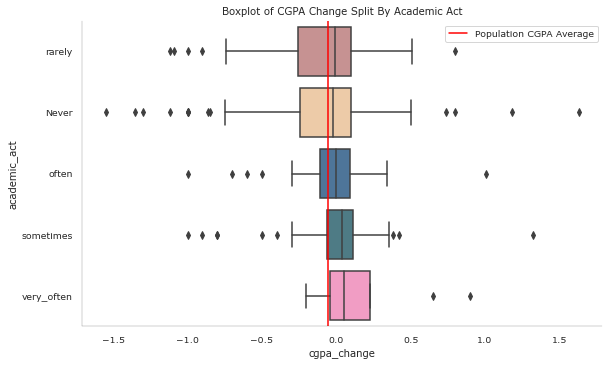

In [48]:
# Visualizing the difference
sns.catplot(
    kind='box',
    data=df_valid_cgpa,
    x='cgpa_change',
    y='academic_act',
    aspect=12/7
)
plt.axvline(df_valid_cgpa.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
plt.title('Boxplot of CGPA Change Split By Academic Act');

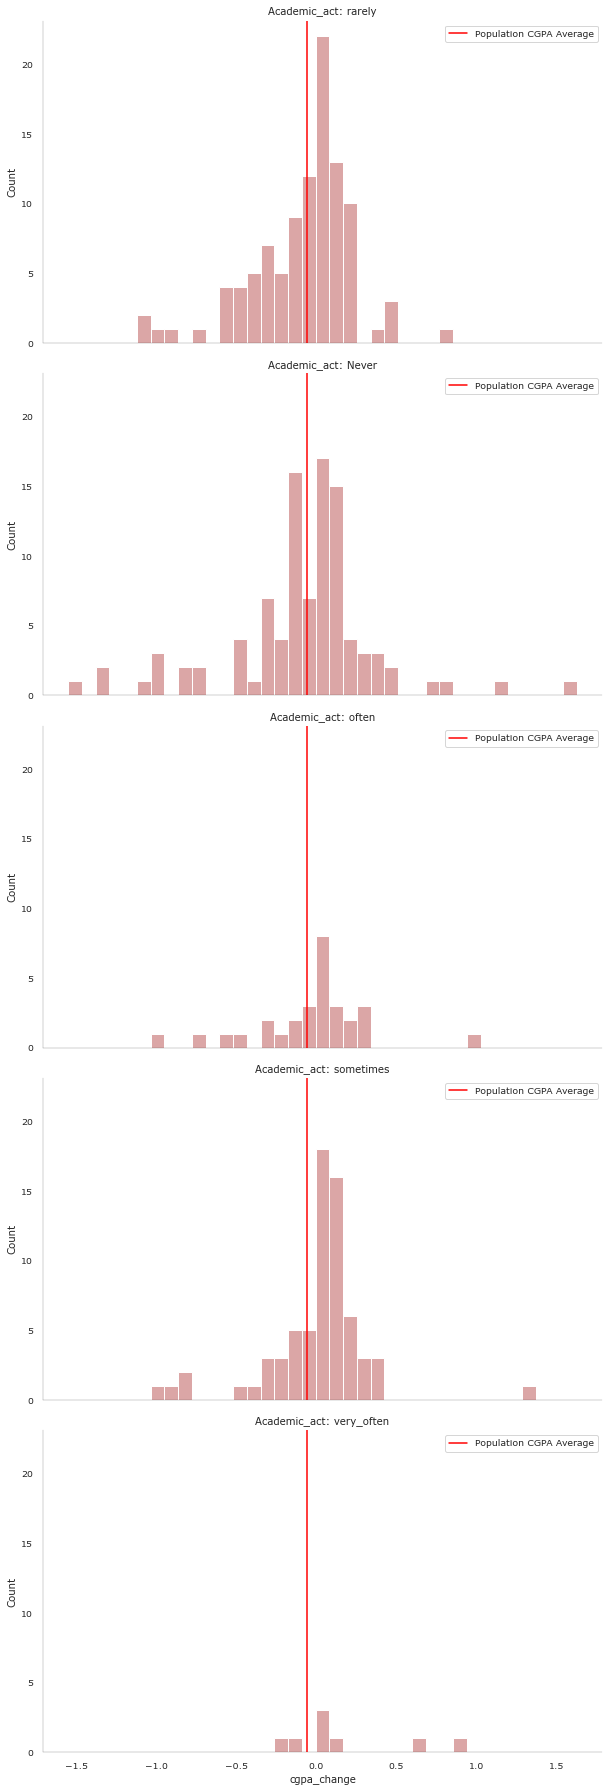

In [49]:
generate_subplots(df_valid_cgpa, x_col='cgpa_change', row_col='academic_act')


In [50]:
# # Get unique values in the 'relationship' column to serve as subplot titles
# unique_labels = df_valid_cgpa['academic_act'].unique()

# # Create subplots using Seaborn, arranging vertically with 'row'
# g = sns.displot(
#     kind='hist',
#     data=df_valid_cgpa,
#     x='cgpa_change',
#     row='academic_act',  
#     aspect=12/7,
#     row_order=unique_labels 
# )

# population_cgpa_average = df_valid_cgpa['cgpa_change'].mean()

# # Loop through each subplot, add the red line, and set the title
# for relationship, ax in zip(unique_labels, g.axes.flat):
#     ax.axvline(population_cgpa_av2'/        erage, color='red', label='Population CGPA Average')
#     ax.legend(loc='upper right')/


# plt.tight_layout()


# plt.show()


The Boxplot and Histogram both confirm that the change in CGPA is independent of Academic_act.                                                                    

# Lecture                                                                                  

Feature: Lecture

Null Hypothesis: There is no difference in the CGPA change across Lecture Effect.

Alternative Hypothesis:There is a difference in the CGPA change across Lecture Effect.

Test Type: Two Tailed Test

Statistical Test: One Way ANOVA Test

Significance Level: 0.05

ANOVA Test Assumptions:
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

## Confirming Assumptions 

In [51]:
lecture_anova_assumptions = anova_assumptions_test(feature='lecture', target='cgpa_change', df=df_valid_cgpa)
print(lecture_anova_assumptions)

The given data passes both tests of homoscedasticity and normality.


## Hypothesis Testing on Lecture Effects.

In [52]:
lecture_hypothesis_test = perform_one_way_anova(feature='lecture', target='cgpa_change', df=df_valid_cgpa)
lecture_hypothesis_test  

'ANOVA F-statistic:", 3.0837176943043434, "ANOVA p-value:", 0.01642350733045032'

The p-value score of 0.0164 is less than the significance level of 0.05 this means that we reject the null hypothesis

**There is a significant difference between the average cgpa change across the different Lecture effects**                                                                     

## Interpreting the difference

While we've confirmed that a significant difference exist among the Lecture Effects. The test carried out tells us nothing about the nature of this difference. To understand this difference, we can carry out post hoc tests to determine which specific pairs or groups differ significantly from the rest.                               

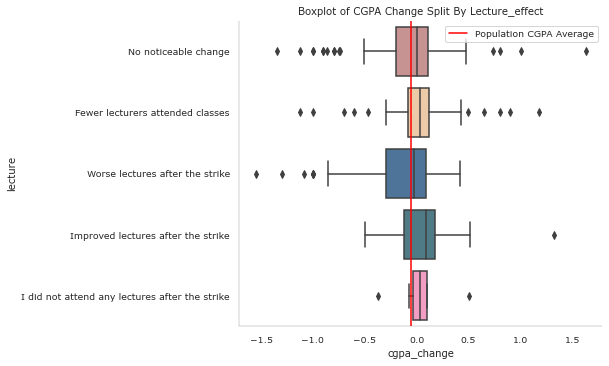

In [53]:
# Visualizing the difference
sns.catplot(
    kind='box',
    data=df_valid_cgpa,
    x='cgpa_change',
    y='lecture',
    aspect=12/7
)
plt.axvline(df_valid_cgpa.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
plt.title('Boxplot of CGPA Change Split By Lecture_effect');

In [54]:
# Investigating pairwise differences                                                                                 
level_tukey_results = perform_pairwise_tukeyhsd(feature='lecture', target='cgpa_change', df=df_valid_cgpa)
level_tukey_results

                                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                                         
                    group1                                         group2                     meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------------------------------------------------
              Fewer lecturers attended classes I did not attend any lectures after the strike   0.0116    1.0  -0.393  0.4161  False
              Fewer lecturers attended classes             Improved lectures after the strike   0.0624 0.9808 -0.2443  0.3692  False
              Fewer lecturers attended classes                           No noticeable change  -0.1013 0.3459 -0.2515  0.0489  False
              Fewer lecturers attended classes                Worse lectures after the strike   -0.175 0.0183 -0.3302 -0.0197   True
I did not attend any lectures after the strike             Improved l

From the table above, the strongest significant change was noticed in a pair containing "Worse Lecture after the strike". The Boxplot also showed that the group had the lowest 2nd quartile, lowest median value, lowest bottom whisker (minimum non-outlier value) and it was also the only group without a positive outlier. This overwhelmingly proves that those with worse lectures after the strike recieved the most negative impact on their CGPA.
          

# Prep Change

Feature: Prep_Change

Null Hypothesis: There is no difference in the CGPA change across Preparation's Effect.

Alternative Hypothesis:There is a difference in the CGPA change across Preparation's Effect.

Test Type: Two Tailed Test

Statistical Test: One Way ANOVA Test

Significance Level: 0.05

ANOVA Test Assumptions:
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

In [55]:
df_valid_cgpa.head(2)

,school,level,age,gender,relationship,faculty,department,strike_effect,challenge,work,skills,prep_before,prep_after,lecture,academic_act,courses_taken,course_unit,cgpa_before,cgpa_after,cgpa_change
0,university of lagos,400 Level,22,Male,Single,Engineering,Chemical engineering,I learned how to study better and my grades al...,Trying to remember things we were taught befor...,Worked in a role relevant to my studies,Acquired skills unrelated to course of study,Poorly,Poorly,No noticeable change,rarely,10,23,3.39,3.51,0.12
1,university of lagos,400 Level,23,Female,Single,Engineering,Chemical engineering,It affected it in a negative way as it became ...,"Rekindling the student in me, lol. Trying to g...",Did not work during the strike,Acquired skills unrelated to course of study,Poorly,Moderately,No noticeable change,rarely,10,23,4.44,4.50,0.06


In [56]:
df_valid_cgpa['prep_after'].unique()

array(['Poorly', 'Moderately', 'Very'], dtype=object)

In [57]:
cols = ['prep_before', 'prep_after', 'cgpa_change']

In [58]:
df_prep_encoded = df_valid_cgpa[cols]

In [59]:
df_prep_encoded.head(2)

,prep_before,prep_after,cgpa_change
0,Poorly,Poorly,0.12
1,Poorly,Moderately,0.06


In [60]:
from sklearn.preprocessing import LabelEncoder


# Define the custom order of labels
custom_order = ['Poorly', 'Moderately', 'Very']

# Initialize the LabelEncoder with custom categories
encoder = LabelEncoder()
encoder.classes_ = custom_order


df_prep_encoded['prep_after'] = encoder.transform(df_prep_encoded['prep_after'])
df_prep_encoded['prep_before'] = encoder.transform(df_prep_encoded['prep_before'])

# #Do the same for 'prep_after'
# df_prep_encoded['prep_after'] = encoder.fit_transform(df_prep_encoded['prep_after'])

# df_valid_cgpa['prep_after'] = df_valid_cgpa['prep_after'].apply(lambda x: custom_order[x])


C:\Users\Modupe\AppData\Local\Temp\ipykernel_7612\969368347.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prep_encoded['prep_after'] = encoder.transform(df_prep_encoded['prep_after'])
C:\Users\Modupe\AppData\Local\Temp\ipykernel_7612\969368347.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prep_encoded['prep_before'] = encoder.transform(df_prep_encoded['prep_before'])


In [61]:
df_prep_encoded.head(2)

,prep_before,prep_after,cgpa_change
0,0,0,0.12
1,0,1,0.06


In [62]:
df_prep_encoded['prep_before'].unique()

array([0, 1, 2])

In [63]:
df_prep_encoded['prep_change'] = df_prep_encoded['prep_after'] - df_prep_encoded['prep_before']

C:\Users\Modupe\AppData\Local\Temp\ipykernel_7612\1350355195.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prep_encoded['prep_change'] = df_prep_encoded['prep_after'] - df_prep_encoded['prep_before']


In [64]:
df_prep_encoded['prep_change'].unique()

array([ 0,  1,  2, -2, -1])

In [65]:
def map_prep_change(value):
    if value > 0:
        return 'positive prep change'
    elif value < 0:
        return 'decreased prep change'
    else:
        return 'no prep change'

# Apply the mapping function to create a new categorical column
df_prep_encoded['prep_change_category'] = df_prep_encoded['prep_change'].apply(map_prep_change)


C:\Users\Modupe\AppData\Local\Temp\ipykernel_7612\262986441.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prep_encoded['prep_change_category'] = df_prep_encoded['prep_change'].apply(map_prep_change)


In [66]:
df_prep_encoded.head(2)

,prep_before,prep_after,cgpa_change,prep_change,prep_change_category
0,0,0,0.12,0,no prep change
1,0,1,0.06,1,positive prep change


In [67]:
df_prep_encoded.prep_change_category.unique()

array(['no prep change', 'positive prep change', 'decreased prep change'],
      dtype=object)

In [68]:
df_prep_encoded[(df_prep_encoded['prep_change_category'] == 'positive prep change')]

,prep_before,prep_after,cgpa_change,prep_change,prep_change_category
1,0,1,0.06,1,positive prep change
3,1,2,0.10,1,positive prep change
4,0,2,-0.85,2,positive prep change
14,0,1,0.10,1,positive prep change
16,0,2,0.00,2,positive prep change
...,...,...,...,...,...
285,0,1,0.10,1,positive prep change
289,0,1,0.32,1,positive prep change
296,0,1,-0.11,1,positive prep change
300,0,1,-0.04,1,positive prep change


## Confirming Assumptions

In [69]:
prep_anova_assumptions = anova_assumptions_test(feature='prep_change_category', target='cgpa_change', df=df_prep_encoded)

print(prep_anova_assumptions)

The given data passes both tests of homoscedasticity and normality.


## Hypothesis Testing on Preparation's effect on CPGA Change 

In [70]:
prep_hypothesis_test = perform_one_way_anova(feature='prep_change_category', target='cgpa_change', df=df_prep_encoded)

prep_hypothesis_test  

'ANOVA F-statistic:", 9.714273034604844, "ANOVA p-value:", 8.152623148871439e-05'

The p-value score of 0.0000815 is less than the significance level of 0.05 this means that the observed effect is likely not due to random chance and is statistically significant.

So p-value ≤ alpha: We reject the null hypothesis

**There is a significant difference between the average cgpa change across the different prep change effects**                                                                     

## Interpreting the difference

While we've confirmed that a significant difference exist among the preparation change. The test carried out tells us nothing about the nature of this difference. To understand this difference, we can carry out post hoc tests to determine which specific pairs or groups differ significantly from the rest.                               

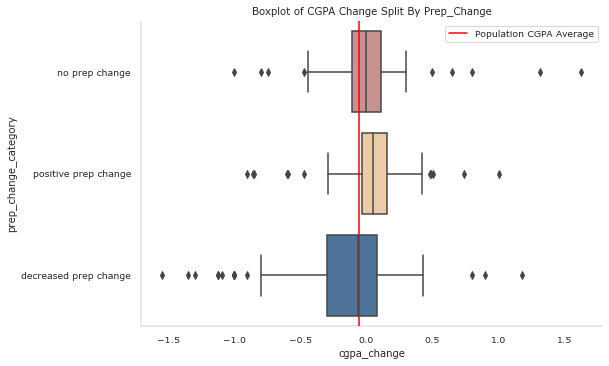

In [71]:
# Visualizing the difference
sns.catplot(
    kind='box',
    data=df_prep_encoded,
    x='cgpa_change',
    y='prep_change_category',
    aspect=12/7
)
plt.axvline(df_prep_encoded.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
plt.title('Boxplot of CGPA Change Split By Prep_Change');

In [72]:
# Investigating pairwise differences                                                                                 
print_tukey_results = perform_pairwise_tukeyhsd(feature='prep_change_category', target='cgpa_change', df=df_prep_encoded)
print_tukey_results

              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
        group1               group2        meandiff p-adj   lower  upper  reject
--------------------------------------------------------------------------------
decreased prep change       no prep change   0.1708 0.0031  0.0488 0.2928   True
decreased prep change positive prep change   0.1993 0.0004  0.0783 0.3203   True
       no prep change positive prep change   0.0285 0.8797 -0.1107 0.1677  False
--------------------------------------------------------------------------------


Based on the Tukey HSD test results, the "decreased prep change" group shows statistically significant differences in means with both "no prep change" and "positive prep change" groups, but there's no significant difference between "no prep change" and "positive prep change" groups.

The significant differences observed between certain groups suggest that there are meaningful distinctions in how these groups are associated with changes in CGPA.

# Self Development (Skill Acquisition)

Feature: Prep_Change

Null Hypothesis: There is no difference in the CGPA change across self dev's Effect.

Alternative Hypothesis:There is a difference in the CGPA change across self dev's Effect.

Test Type: Two Tailed Test

Statistical Test: One Way ANOVA Test

Significance Level: 0.05

ANOVA Test Assumptions:
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

In [73]:
df_valid_cgpa['skills'].unique()

array(['Acquired skills unrelated to course of study',
       'Volunteered for an event or organization, Acquired skills unrelated to course of study',
       'None of the above', 'Volunteered for an event or organization',
       'Acquired skills relevant to course of study, Acquired skills unrelated to course of study',
       'Vocational training and artisanship',
       'Acquired skills relevant to course of study',
       'Acquired skills unrelated to course of study, Vocational training and artisanship',
       'Volunteered for an event or organization, Acquired skills relevant to course of study, Acquired skills unrelated to course of study',
       'Vocational training and artisanship, None of the above',
       'Acquired skills relevant to course of study, Acquired skills unrelated to course of study, Vocational training and artisanship',
       'Volunteered for an event or organization, Acquired skills unrelated to course of study, Vocational training and artisanship',
      

In [74]:
# df_valid_cgpa[df_valid_cgpa['skills'].str.contains('Acquired skills unrelated to course of study', case=False, na=False)]


In [75]:
labels = df_valid_cgpa['skills'].values

In [76]:
len(labels)

305

In [77]:
transformed_labels = []
for label in labels:
    if 'Acquired skills relevant to course of study' in label:
        transformed_labels.append('Acquired skills relevant to course of study')
    elif 'Acquired skills unrelated to course of study' in label:
        transformed_labels.append('Acquired skills unrelated to course of study')
    elif 'Acquired skills relevant to course of study' in label and 'Acquired skills unrelated to course of study' in label:
        transformed_labels.append('Acquired skills relevant to course of study')
    elif 'Volunteered for an event or organization' in label or 'Vocational training and artisanship' in label:
        if 'Acquired skills unrelated to course of study' not in label and 'Acquired skills relevant to course of study' not in label:
            transformed_labels.append('Vocational skills acquired')
    elif 'None of the above' in label:
        if 'Vocational training and artisanship' not in label:
            transformed_labels.append('No skills acquired')
    else:
        transformed_labels.append(label)
        
        


In [78]:
len(transformed_labels)

305

In [79]:
df_self_dev = df_valid_cgpa.copy()

df_self_dev['skills'] = transformed_labels

In [80]:
df_self_dev.tail(3)

,school,level,age,gender,relationship,faculty,department,strike_effect,challenge,work,skills,prep_before,prep_after,lecture,academic_act,courses_taken,course_unit,cgpa_before,cgpa_after,cgpa_change
310,university of lagos,200 Level,30,Male,Single,Management Science,Accounting,"It has really affect my service year,enlogated...","It affected my grades,but all thanks to God.",Worked in a role relevant to my studies,Acquired skills relevant to course of study,Moderately,Moderately,Fewer lecturers attended classes,sometimes,7,18,4.56,4.56,0.00
311,university of lagos,300 Level,21,Male,Single,Sciences,Physics,Business dey go,Reading,Worked in a role unrelated to my studies,Acquired skills unrelated to course of study,Poorly,Moderately,No noticeable change,Never,8,22,3.69,3.47,-0.22
312,university of lagos,400 Level,22,Male,Single,Engineering,Systems engineering,NaN,NaN,Worked in a role unrelated to my studies,Acquired skills unrelated to course of study,Very,Poorly,Fewer lecturers attended classes,Never,10,23,3.20,3.07,-0.13


In [81]:
df_self_dev['skills'].unique()

array(['Acquired skills unrelated to course of study',
       'No skills acquired', 'Vocational skills acquired',
       'Acquired skills relevant to course of study'], dtype=object)

## Confirming Assumptions

In [82]:
skills_anova_assumptions = anova_assumptions_test(feature='skills', target='cgpa_change', df=df_self_dev)

print(skills_anova_assumptions)

The given data passes both tests of homoscedasticity and normality.


## Hypothesis Testing on Self Development effect on CPGA Change 

In [83]:
skills_hypothesis_test = perform_one_way_anova(feature='skills', target='cgpa_change', df=df_self_dev)

skills_hypothesis_test  

'ANOVA F-statistic:", 1.7565161777851446, "ANOVA p-value:", 0.15553571478344047'

The p-value score of 0.156 is greater than the significance level of 0.05.

So p-value > alpha: this means that we fail to reject the null hypothesis.

**There is no significant difference between the average cgpa change across the different self development activities**                                                                     



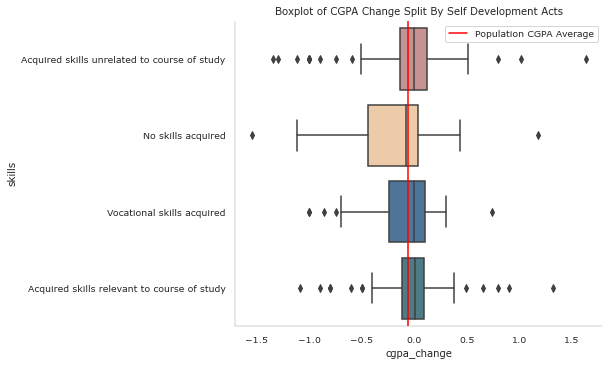

In [84]:
# Visualizing the difference or lack of difference
sns.catplot(
    kind='box',
    data=df_self_dev,
    x='cgpa_change',
    y='skills',
    aspect=12/7
)
plt.axvline(df_self_dev.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
plt.title('Boxplot of CGPA Change Split By Self Development Acts');

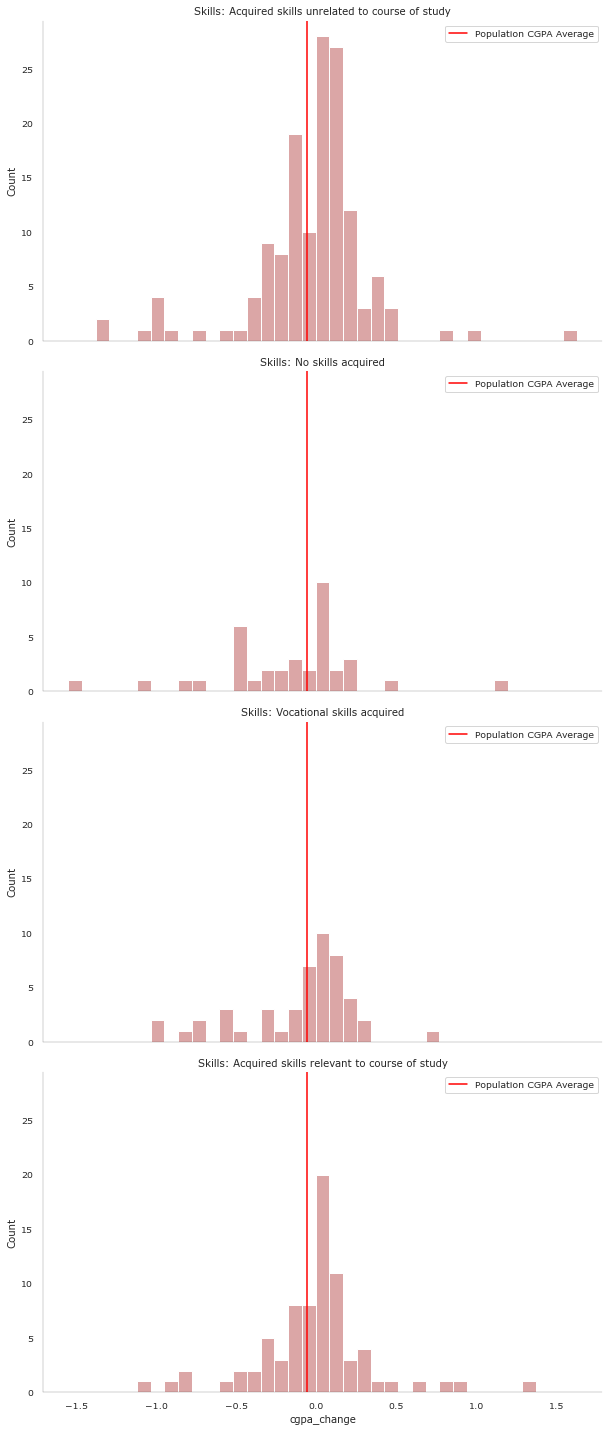

In [85]:
generate_subplots(df_self_dev, x_col='cgpa_change', row_col='skills')


The p-value obtained from the hypothesis test is 0.156, which is greater than the chosen significance level of 0.05. As a result, we fail to reject the null hypothesis. This suggests that there is not enough evidence to conclude a significant difference. Additionally, the accompanying box plot visually supports this finding, showing overlapping distributions between the groups.

# No of Course Units

Feature: Course Units

Null Hypothesis: There is no difference in the CGPA change across No of Course Units Effect.

Alternative Hypothesis:There is a difference in the CGPA change across No of Course Units Effect.

Test Type: Two Tailed Test

Statistical Test: One Way ANOVA Test

Significance Level: 0.05

ANOVA Test Assumptions:
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

In [86]:
df_valid_cgpa[(df_valid_cgpa['course_unit'] > 24)].head(2)

,school,level,age,gender,relationship,faculty,department,strike_effect,challenge,work,skills,prep_before,prep_after,lecture,academic_act,courses_taken,course_unit,cgpa_before,cgpa_after,cgpa_change
31,university of lagos,300 Level,28,Female,Single,Education,Education administration,"My academic performance has reduced, because I...",Reading,Worked in a role unrelated to my studies,Vocational training and artisanship,Very,Moderately,Fewer lecturers attended classes,often,8,25,3.25,2.55,-0.7
70,university of ibadan,300 Level,22,Male,Single,Social Sciences,Economics,Reduced enthusiasm for academic related activi...,Refocusing,Worked in a role relevant to my studies,Acquired skills relevant to course of study,Moderately,Moderately,Worse lectures after the strike,Never,10,30,2.80,2.70,-0.1


In [87]:
df_valid_cgpa[(df_valid_cgpa['course_unit'] == 1)].head(2)

,school,level,age,gender,relationship,faculty,department,strike_effect,challenge,work,skills,prep_before,prep_after,lecture,academic_act,courses_taken,course_unit,cgpa_before,cgpa_after,cgpa_change
3,university of lagos,400 Level,29,Male,Dating,Social Sciences,Political science,Good,Reading,Worked in a role unrelated to my studies,Acquired skills unrelated to course of study,Moderately,Very,No noticeable change,rarely,7,1,3.86,3.96,0.1
9,university of lagos,500 Level,25,Male,Single,Engineering,Surveying & geo-informatics engineering,Still the same,Prolonged graduating date,Worked in a role unrelated to my studies,Acquired skills unrelated to course of study,Moderately,Moderately,Worse lectures after the strike,often,10,1,3.42,3.72,0.3


***There is a noticed problem, some course units have less values than the no of courses taken which should not be possible***

***Let's take another approach***

In [88]:
# Extract rows where the value in 'column1' is NOT smaller than the value in 'column2'
# and where the value in 'column3' is NOT greater than 24

valid_course_unit = df_valid_cgpa[(df_valid_cgpa['course_unit'] > df_valid_cgpa['courses_taken']) & (df_valid_cgpa['course_unit'] <= 24)]


In [89]:
valid_course_unit['course_unit'].unique()

array([23, 18, 15, 21, 20,  9, 16, 22, 24, 17, 19, 12,  8, 14, 13, 10, 11],
      dtype=int64)

##### Convert the numerical values to a categorical representation for the ANOVA Test

In [90]:
def course_units(row):
    if row >= 0 and row < 8:
        return 'Range: 0 - 7'
    elif row >= 8 and row < 16:
        return 'Range: 8 - 15'
    else:
        return 'Range: 16 - 24'

In [91]:
valid_course_unit['course_units_cat'] = valid_course_unit.course_unit.apply(course_units)

C:\Users\Modupe\AppData\Local\Temp\ipykernel_7612\321468735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_course_unit['course_units_cat'] = valid_course_unit.course_unit.apply(course_units)


In [92]:
valid_course_unit = valid_course_unit.reset_index(drop=True)

In [93]:
valid_course_unit[(valid_course_unit['course_units_cat'] == 'Range: 8 - 15')].head(2)

,school,level,age,gender,relationship,faculty,department,strike_effect,challenge,work,...,prep_before,prep_after,lecture,academic_act,courses_taken,course_unit,cgpa_before,cgpa_after,cgpa_change,course_units_cat
4,university of lagos,200 Level,20,Female,Single,Sciences,Statistics,NaN,NaN,Worked in a role unrelated to my studies,...,Moderately,Moderately,No noticeable change,rarely,5,15,4.00,3.80,-0.20,Range: 8 - 15
8,university of lagos,400 Level,22,Female,Single,Sciences,Marine science,Extra 1.7 months addition to normal graduation...,The uncertainty,Worked in a role unrelated to my studies,...,Very,Moderately,No noticeable change,rarely,3,9,4.16,4.08,-0.08,Range: 8 - 15


## Confirming Assumptions

In [94]:
course_anova_assumptions = anova_assumptions_test(feature='course_units_cat', target='cgpa_change', df=valid_course_unit)

print(course_anova_assumptions)

The given data passes both tests of homoscedasticity and normality.


## Hypothesis Testing of Course Units on CGPA Change

In [95]:
course_hypothesis_test = perform_one_way_anova(feature='course_units_cat', target='cgpa_change', df=valid_course_unit)

course_hypothesis_test  

'ANOVA F-statistic:", 0.6126395035652697, "ANOVA p-value:", 0.43464903888538864'

The p-value score of 0.435 is greater than the significance level of 0.05.

So p-value > alpha: this means that we fail to reject the null hypothesis.

**There is no significant difference between the average cgpa change across the different course units groups**                                                                     



### Visualizing the difference or lack of difference

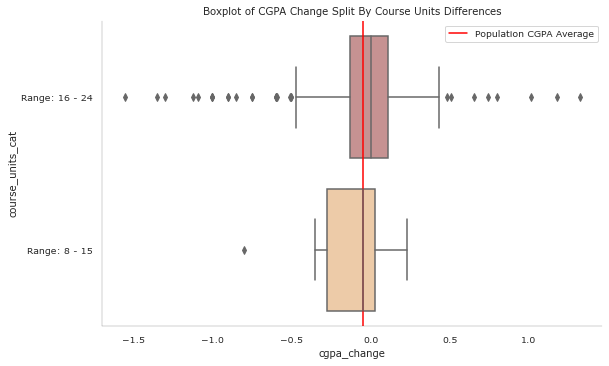

In [96]:
sns.catplot(
    kind='box',
    data=valid_course_unit,
    x='cgpa_change',
    y='course_units_cat',
    aspect=12/7
)
plt.axvline(valid_course_unit.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
plt.title('Boxplot of CGPA Change Split By Course Units Differences');

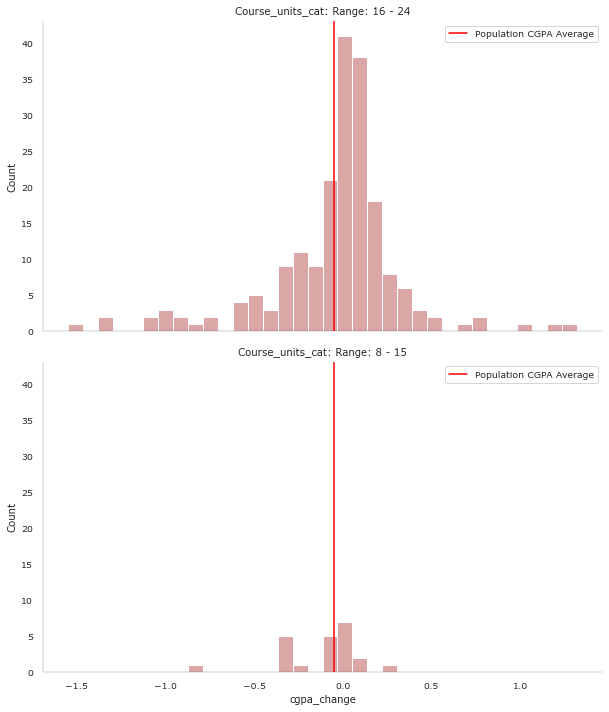

In [97]:
generate_subplots(valid_course_unit, x_col='cgpa_change', row_col='course_units_cat')
